In [3]:
import pandas as pd
import src.config as config
import os

MODEL_NAME = 'EfficientNetB0'
INPUT_PATH = config.OUTPUT_FEATEXT_DATA

TRAIN_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'train.csv')
TRAIN_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_train.csv')
VAL_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'valid.csv')
VAL_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_valid.csv')
TEST_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'test.csv')
TEST_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_test.csv')

In [49]:
X_train_prep, y_train = pd.read_csv(TRAIN_DATA_PATH), pd.read_csv(TRAIN_LABELS_PATH)
X_valid_prep, y_valid = pd.read_csv(VAL_DATA_PATH), pd.read_csv(VAL_LABELS_PATH)
X_test_prep, y_test = pd.read_csv(TEST_DATA_PATH), pd.read_csv(TEST_LABELS_PATH)

ls_feats_umap = [col for col in X_train_prep.columns if 'umap' in col]
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_prep[ls_feats_umap] = sc.fit_transform(X_train_prep[ls_feats_umap])
X_valid_prep[ls_feats_umap] = sc.transform(X_valid_prep[ls_feats_umap])
X_test_prep[ls_feats_umap] = sc.transform(X_test_prep[ls_feats_umap])

print("Data Size:")
print("Train:", X_train_prep.shape, y_train.shape)
print("Valid:", X_valid_prep.shape, y_valid.shape)
print("Test:", X_test_prep.shape, y_test.shape)

Data Size:
Train: (20300, 15) (20300, 1)
Valid: (1450, 15) (1450, 1)
Test: (15657, 15) (15657, 1)


In [22]:
# Calculate CV Score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

model = XGBClassifier()

def train_model_cv(model, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train = y_train.values.ravel()
    y_val = y_val.values.ravel()
    y_test = y_test.values.ravel()

    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', verbose=0)
    print("CV Scores:", cv_score)

    acc_mean = cv_score.mean()
    acc_std = cv_score.std()
    print(f"CV Score: {acc_mean:.4f}+-{acc_std:.4f}")

    # Train Model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred)
    print("Validation Accuracy:", acc_val)

    # Predict
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    print("Test Accuracy:", acc_test)
    return model, acc_mean, acc_val, acc_test

train_model_cv(model, X_train_prep, y_train, X_valid_prep, y_valid, X_test_prep, y_test);

CV Scores: [0.95147783 0.95492611 0.95123153 0.96108374 0.78743842]
CV Score: 0.9212+-0.0670
Validation Accuracy: 0.6675862068965517
Test Accuracy: 0.6332630772178578


In [50]:
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

xgb = XGBClassifier(n_jobs=-1)
lsvm = LinearSVC(dual='auto')
svm = SVC()
rf = RandomForestClassifier(n_jobs=-1)
vc = VotingClassifier(estimators=[('xgb', xgb), ('lsvm', lsvm), ('svm', svm), ('rf', rf)], voting='hard', n_jobs=-1)

ls_models = [xgb, lsvm, svm, rf, vc]
d_results = {}
for model in ls_models:
    print("Model:", model.__class__.__name__)
    model, acc_mean, acc_val, acc_test = train_model_cv(model, X_train_prep, y_train, 
                                                        X_valid_prep, y_valid, X_test_prep, y_test)
    d_results[model.__class__.__name__] = {'model': model, 'CV_accuracy': acc_mean,
                                             'val_accuracy': acc_val, 'test_accuracy': acc_test}
    

Model: XGBClassifier
CV Scores: [0.95147783 0.95492611 0.95123153 0.96108374 0.78743842]
CV Score: 0.9212+-0.0670
Validation Accuracy: 0.6675862068965517
Test Accuracy: 0.6332630772178578
Model: LinearSVC
CV Scores: [0.84014778 0.8682266  0.87093596 0.88374384 0.57463054]
CV Score: 0.8075+-0.1173
Validation Accuracy: 0.6351724137931034
Test Accuracy: 0.6169764322667177
Model: SVC
CV Scores: [0.91108374 0.92487685 0.91428571 0.91576355 0.708867  ]
CV Score: 0.8750+-0.0832
Validation Accuracy: 0.6586206896551724
Test Accuracy: 0.6352430222903493
Model: RandomForestClassifier
CV Scores: [0.95418719 0.96083744 0.95517241 0.96108374 0.77142857]
CV Score: 0.9205+-0.0746
Validation Accuracy: 0.6655172413793103
Test Accuracy: 0.632113431691895
Model: VotingClassifier
CV Scores: [0.9453202  0.94926108 0.94162562 0.94753695 0.71871921]
CV Score: 0.9005+-0.0909
Validation Accuracy: 0.6675862068965517
Test Accuracy: 0.6428434566008814


In [51]:
df_res = pd.DataFrame(d_results).T
df_res

,model,CV_accuracy,val_accuracy,test_accuracy
XGBClassifier,"XGBClassifier(base_score=None, booster=None, c...",0.921232,0.667586,0.633263
LinearSVC,LinearSVC(dual='auto'),0.807537,0.635172,0.616976
SVC,SVC(),0.874975,0.658621,0.635243
RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', r...",0.920542,0.665517,0.632113
VotingClassifier,"VotingClassifier(estimators=[('xgb',\n ...",0.900493,0.667586,0.642843


In [52]:
xgb_imp = d_results['XGBClassifier']['model'].feature_importances_
rf_imp = d_results['RandomForestClassifier']['model'].feature_importances_
lsvc_imp = np.abs(d_results['LinearSVC']['model'].coef_).mean(axis=0)
lsvc_imp = lsvc_imp / lsvc_imp.sum()

<Axes: >

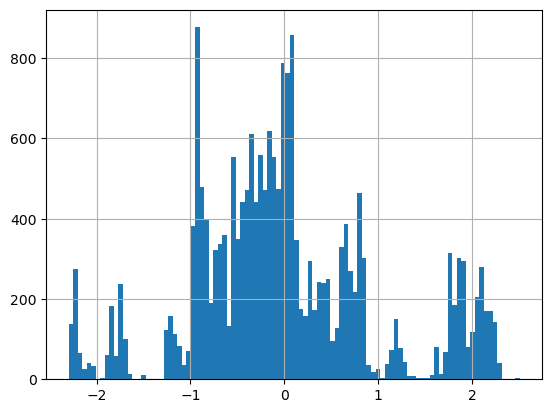

In [59]:
X_train_prep['umap_6'].hist(bins=100)

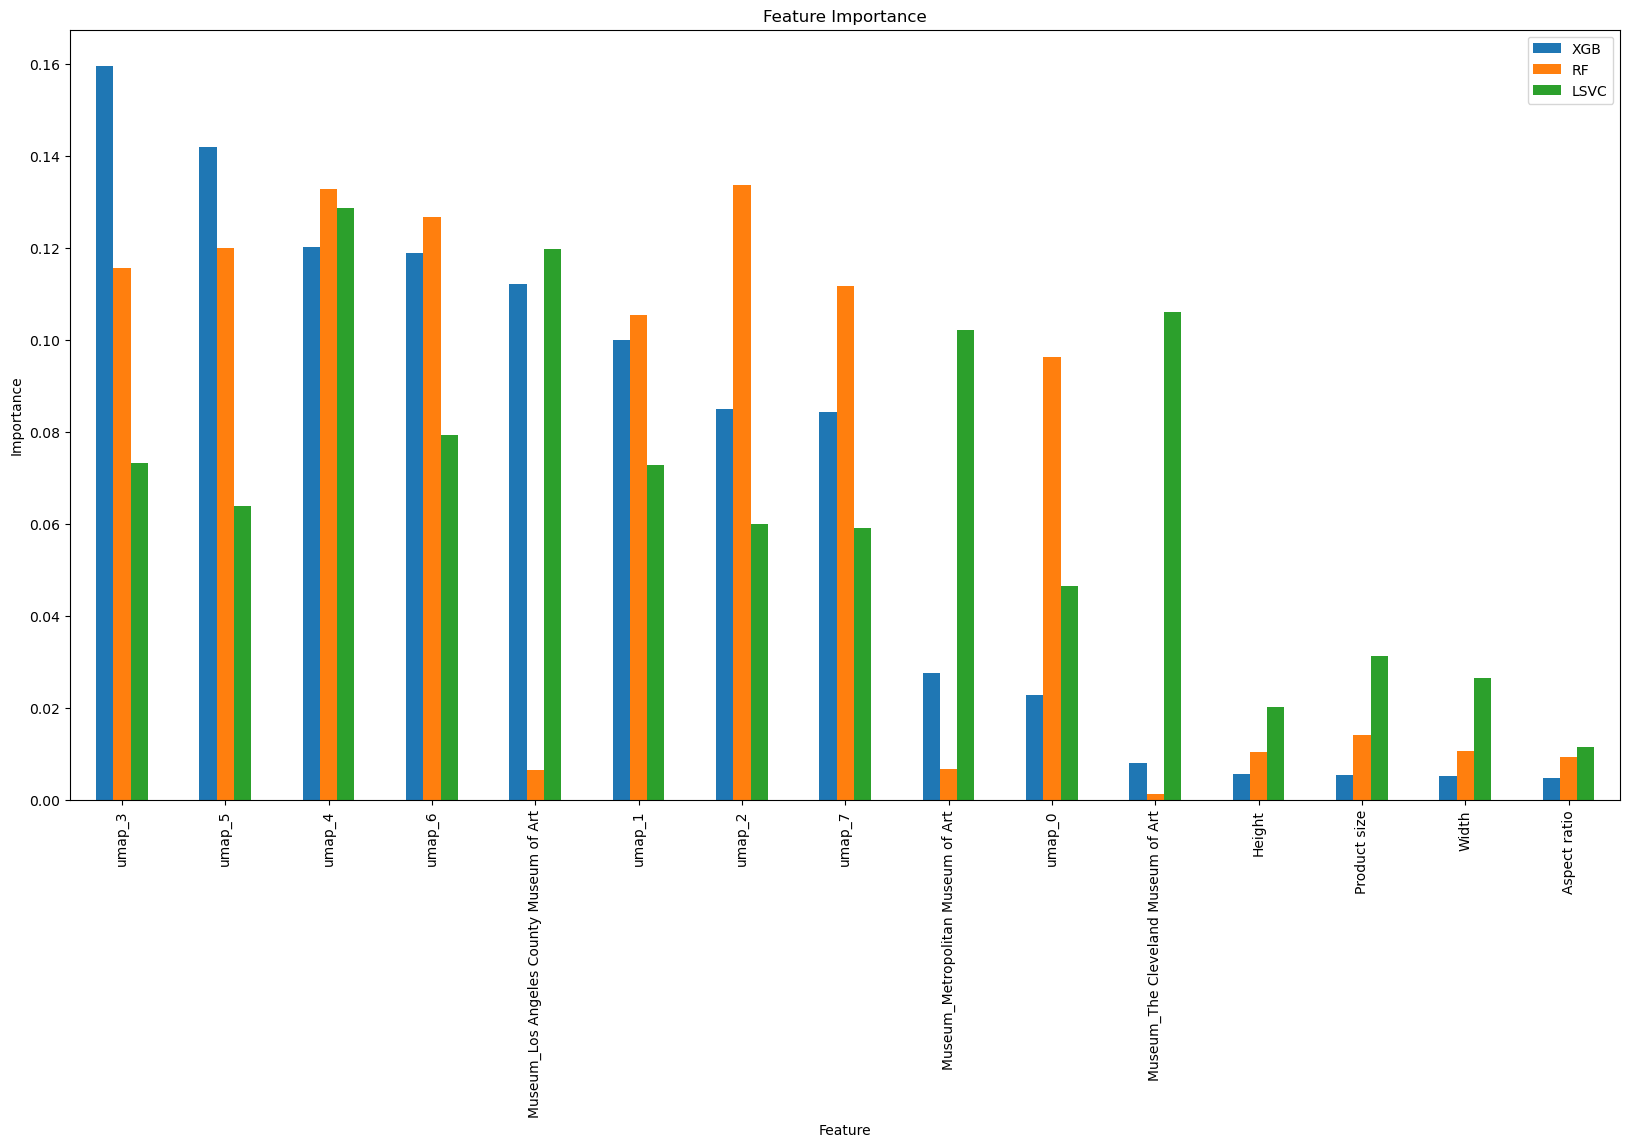

In [54]:
df_imp = pd.DataFrame({'XGB': xgb_imp, 'RF': rf_imp, 'LSVC': lsvc_imp}, index=X_train_prep.columns)
df_imp = df_imp.sort_values(by='XGB', ascending=False)
df_imp.plot(kind='bar', figsize=(20, 10), title='Feature Importance', xlabel='Feature', ylabel='Importance');

In [69]:
arr = np.array([[1, 2, 3], [4, 5, 6]])
arr.flatten()

array([1, 2, 3, 4, 5, 6])

In [2]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import src.config as config
import os
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

def train_model_cv(model, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train = y_train.values.ravel()
    y_val = y_val.values.ravel()
    y_test = y_test.values.ravel()

    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', verbose=0)
    print("CV Scores:", cv_score)

    acc_mean = cv_score.mean()
    acc_std = cv_score.std()
    print(f"CV Score: {acc_mean:.4f}+-{acc_std:.4f}")

    # Train Model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred)
    print("Validation Accuracy:", acc_val)

    # Predict
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    print("Test Accuracy:", acc_test)
    return model, acc_mean, acc_val, acc_test


def train_extracted_features(MODEL_NAME):
    INPUT_PATH = config.OUTPUT_FEATMED_DATA

    TRAIN_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'train.csv')
    TRAIN_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_train.csv')
    VAL_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'valid.csv')
    VAL_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_valid.csv')
    TEST_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'test.csv')
    TEST_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_test.csv')

    X_train_prep, y_train = pd.read_csv(TRAIN_DATA_PATH), pd.read_csv(TRAIN_LABELS_PATH)
    X_valid_prep, y_valid = pd.read_csv(VAL_DATA_PATH), pd.read_csv(VAL_LABELS_PATH)
    X_test_prep, y_test = pd.read_csv(TEST_DATA_PATH), pd.read_csv(TEST_LABELS_PATH)

    ls_feats_umap = [col for col in X_train_prep.columns if 'umap' in col]

    sc = StandardScaler()
    X_train_prep[ls_feats_umap] = sc.fit_transform(X_train_prep[ls_feats_umap])
    X_valid_prep[ls_feats_umap] = sc.transform(X_valid_prep[ls_feats_umap])
    X_test_prep[ls_feats_umap] = sc.transform(X_test_prep[ls_feats_umap])

    xgb = XGBClassifier(n_jobs=-1)
    lsvm = LinearSVC(dual='auto')
    svm = SVC()
    rf = RandomForestClassifier(n_jobs=-1)
    vc = VotingClassifier(estimators=[('xgb', xgb), ('lsvm', lsvm), 
                                      ('svm', svm), ('rf', rf)], 
                          voting='hard', n_jobs=-1)

    ls_models = [xgb, lsvm, svm, rf, vc]
    d_results = {}
    for model in ls_models:
        print("Model:", model.__class__.__name__)
        model, acc_mean, acc_val, acc_test = train_model_cv(model, X_train_prep, y_train, 
                                                            X_valid_prep, y_valid, X_test_prep, y_test)
        d_results[model.__class__.__name__] = {'model_name': model.__class__.__name__, 
                                               'trained_model': model, 'CV_accuracy': acc_mean,
                                                'val_accuracy': acc_val, 'test_accuracy': acc_test}
        
    return d_results

model_names = ["ResNet50", "VGG16", "EfficientNetB0", "EfficientNetB3"]

df_model_comp = pd.DataFrame()
for model_name in model_names:
    print("Model:", model_name)
    d_ex = train_extracted_features(model_name)
    df_ = pd.DataFrame(d_ex).T
    df_["extractor"] = model_name
    df_model_comp = pd.concat([df_model_comp, df_], ignore_index=True)

df_model_comp

Model: ResNet50
Model: XGBClassifier
CV Scores: [0.68669951 0.69334975 0.70492611 0.708867   0.43743842]
CV Score: 0.6463+-0.1047
Validation Accuracy: 0.5517241379310345
Test Accuracy: 0.5352238615315833
Model: LinearSVC
CV Scores: [0.34014778 0.35862069 0.34581281 0.39187192 0.22463054]
CV Score: 0.3322+-0.0567
Validation Accuracy: 0.3482758620689655
Test Accuracy: 0.3295650507760107
Model: SVC
CV Scores: [0.49137931 0.51625616 0.51551724 0.52512315 0.31773399]
CV Score: 0.4732+-0.0785
Validation Accuracy: 0.48413793103448277
Test Accuracy: 0.4655425688190586
Model: RandomForestClassifier
CV Scores: [0.67487685 0.69605911 0.70566502 0.71970443 0.43054187]
CV Score: 0.6454+-0.1084
Validation Accuracy: 0.5537931034482758
Test Accuracy: 0.5283898575716932
Model: VotingClassifier
CV Scores: [0.61674877 0.63768473 0.65172414 0.6455665  0.39285714]
CV Score: 0.5889+-0.0987
Validation Accuracy: 0.5248275862068965
Test Accuracy: 0.5133167273424027
Model: VGG16
Model: XGBClassifier
CV Scores: 

,model_name,trained_model,CV_accuracy,val_accuracy,test_accuracy,extractor
0,XGBClassifier,"XGBClassifier(base_score=None, booster=None, c...",0.646256,0.551724,0.535224,ResNet50
1,LinearSVC,LinearSVC(dual='auto'),0.332217,0.348276,0.329565,ResNet50
2,SVC,SVC(),0.473202,0.484138,0.465543,ResNet50
3,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', r...",0.645369,0.553793,0.52839,ResNet50
4,VotingClassifier,"VotingClassifier(estimators=[('xgb',\n ...",0.588916,0.524828,0.513317,ResNet50
5,XGBClassifier,"XGBClassifier(base_score=None, booster=None, c...",0.646601,0.546207,0.534202,VGG16
6,LinearSVC,LinearSVC(dual='auto'),0.336453,0.353793,0.329565,VGG16
7,SVC,SVC(),0.475616,0.48,0.465543,VGG16
8,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', r...",0.647537,0.531724,0.535032,VGG16
9,VotingClassifier,"VotingClassifier(estimators=[('xgb',\n ...",0.591576,0.528966,0.513189,VGG16


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Feature Extraction Model Comparison')

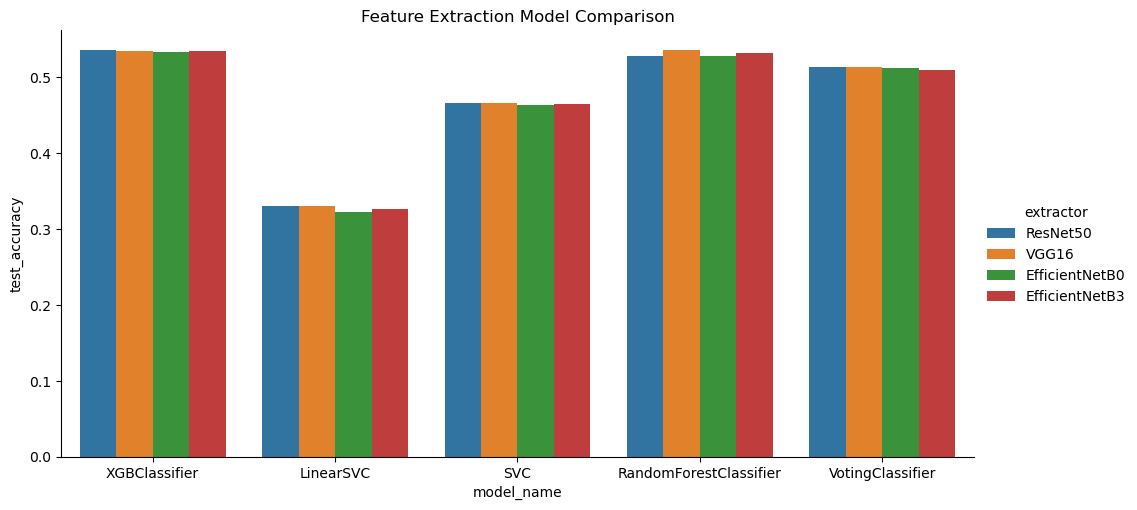

In [4]:
df_model_aux = df_model_comp[['extractor', 'model_name', 'test_accuracy']].copy()
# df_model_aux.set_index(['extractor'], inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt
sns.catplot(data=df_model_aux, kind='bar', x='model_name', y='test_accuracy', hue='extractor',
            height=5, aspect=2, legend=True);

plt.title("Feature Extraction Model Comparison")

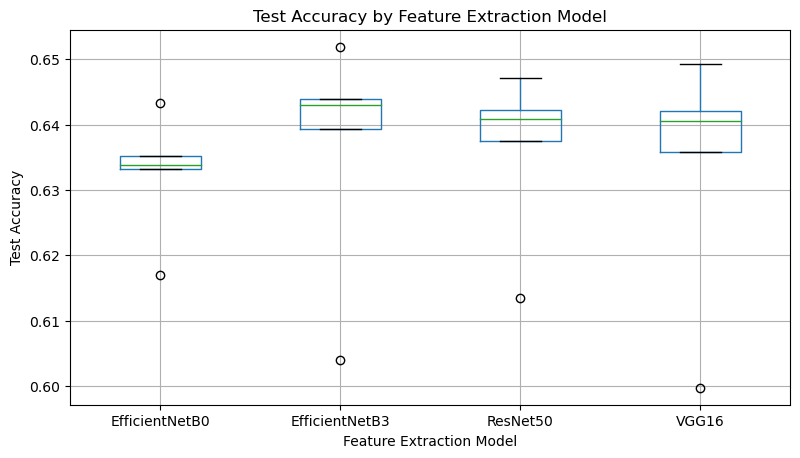

In [68]:
df_model_comp.boxplot(column='test_accuracy', by='extractor', figsize=(9, 5))
plt.title("Test Accuracy by Feature Extraction Model")
plt.xlabel("Feature Extraction Model")
plt.ylabel("Test Accuracy")
plt.suptitle("");

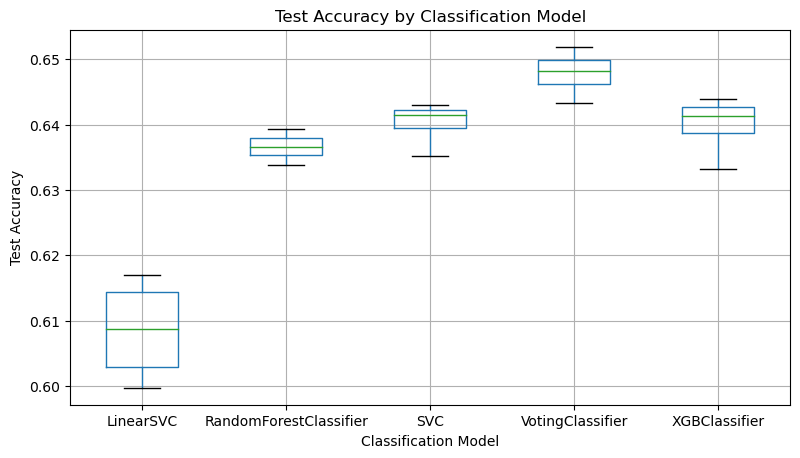

In [67]:
df_model_comp.boxplot(column='test_accuracy', by='model_name', figsize=(9, 5))
plt.title("Test Accuracy by Classification Model")
plt.xlabel("Classification Model")
plt.ylabel("Test Accuracy")
plt.suptitle("");

In [ ]:
xgb.feature_names_in_

Text(0.5, 1.0, 'Feature Importance for EfficientNetB3 + XGBoost')

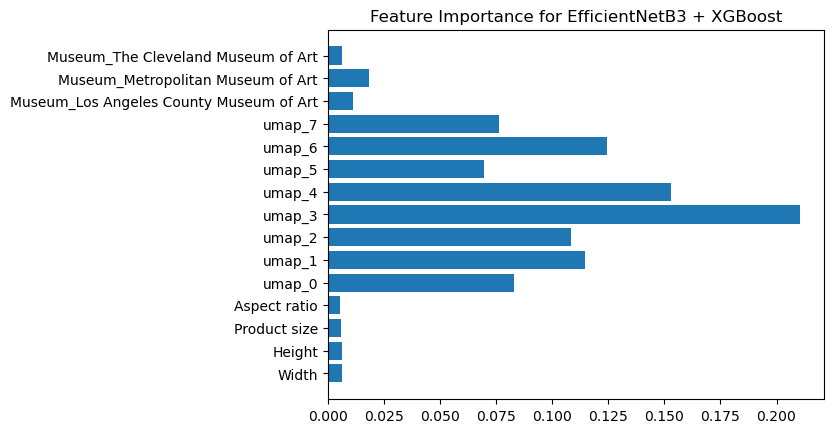

In [82]:
df_effb3 = df_model_comp[df_model_comp['extractor'] == 'EfficientNetB3']
xgb_imp = df_effb3[df_effb3["model_name"] == 'XGBClassifier']['trained_model'].iloc[0]

plt.barh(xgb_imp.feature_names_in_, xgb_imp.feature_importances_)
plt.title("Feature Importance for EfficientNetB3 + XGBoost")

Text(0.5, 1.0, 'Feature Importance for EfficientNetB3 + RandomForesClassifier')

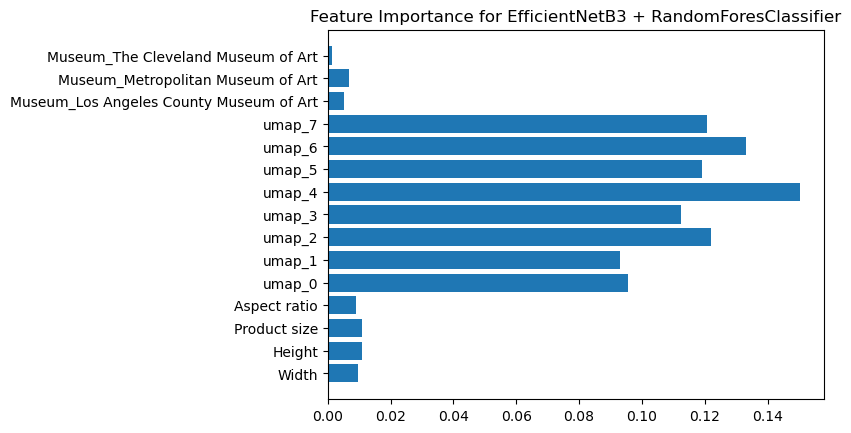

In [83]:
df_effb3 = df_model_comp[df_model_comp['extractor'] == 'EfficientNetB3']
rf_imp = df_effb3[df_effb3["model_name"] == 'RandomForestClassifier']['trained_model'].iloc[0]

plt.barh(rf_imp.feature_names_in_, rf_imp.feature_importances_)
plt.title("Feature Importance for EfficientNetB3 + RandomForestClassifier")

In [96]:
df_effb3 = df_model_comp[df_model_comp['extractor'] == 'EfficientNetB3']
lsvc_imp = df_effb3[df_effb3["model_name"] == 'LinearSVC']['trained_model'].iloc[0].coef_
lsvc_imp = np.abs(lsvc_imp.mean(axis=0)) / np.abs(lsvc_imp.mean(axis=0)).sum()

# plt.barh(rf_imp.feature_names_in_, rf_imp.feature_importances_)
# plt.title("Feature Importance for EfficientNetB3 + RandomForestClassifier")


In [97]:
lsvc_imp

array([0.01668147, 0.01650813, 0.04389155, 0.00143446, 0.0302184 ,
       0.02842566, 0.01474443, 0.0449481 , 0.07774836, 0.06021717,
       0.03672973, 0.002627  , 0.2450453 , 0.17168193, 0.20909831])

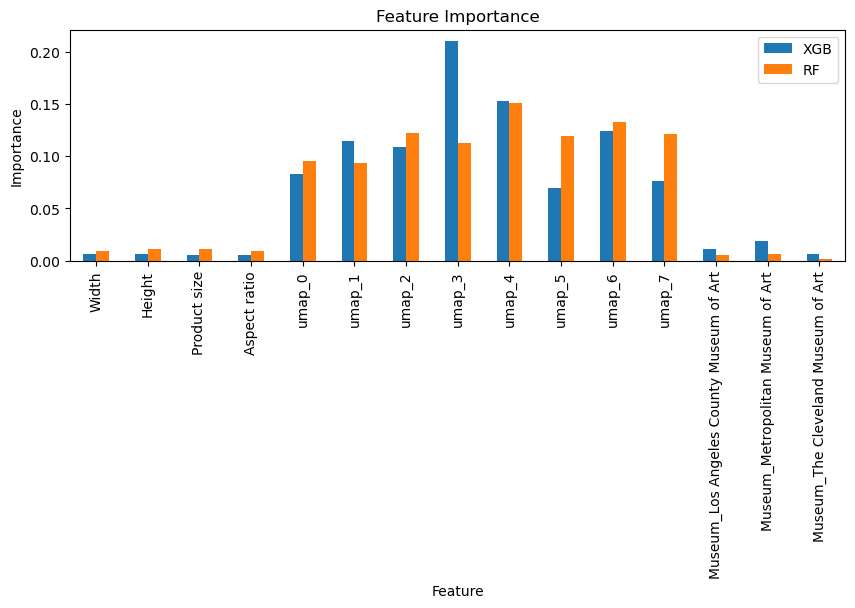

In [104]:
df_imp = pd.DataFrame({'XGB': xgb_imp.feature_importances_, 'RF': rf_imp.feature_importances_}, index=X_train_prep.columns)
# df_imp = df_imp.sort_values(by='XGB', ascending=False)
df_imp.plot(kind='bar', figsize=(10, 3), title='Feature Importance', xlabel='Feature', ylabel='Importance');

In [ ]:
xgb_imp = d_results['XGBClassifier']['model'].feature_importances_
rf_imp = d_results['RandomForestClassifier']['model'].feature_importances_
lsvc_imp = np.abs(d_results['LinearSVC']['model'].coef_).mean(axis=0)
lsvc_imp = lsvc_imp / lsvc_imp.sum()

In [55]:
from bayes_opt import BayesianOptimization, UtilityFunction
# Numpy import

import numpy as np



# SK Learn imports

from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def internal_method(n_estimators, max_depth, learning_rate):

    # C: SVC hyper parameter to optimize for.
    model = XGBClassifier(n_jobs=-1, n_estimators=int(n_estimators), 
                          max_depth=int(max_depth), learning_rate=learning_rate,
                          random_state=7, )
    model.fit(X_train_prep, y_train.values.ravel())
    y_pred = model.predict(X_valid_prep)
    f = accuracy_score(y_valid.values.ravel(), y_pred)
    return f

# bayes_opt requires this to be a dictionary.
bds = {"n_estimators": (100, 1000),
       "max_depth": (1, 10),
       "learning_rate": (0.01, 1)}

# Create a BayesianOptimization optimizer and optimize the function
optimizer = BayesianOptimization(f = internal_method,
                                 pbounds = bds,
                                 random_state = 7,
                                 verbose=2)

optimizer.maximize(init_points=5, n_iter=5)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.6676    | 0.08555   | 8.019     | 494.6     |
| 2         | 0.6172    | 0.7262    | 9.802     | 584.6     |
| 3         | 0.6662    | 0.5061    | 1.648     | 341.6     |
| 4         | 0.6634    | 0.5049    | 7.113     | 823.4     |
| 5         | 0.6697    | 0.3871    | 1.593     | 359.3     |
| 6         | 0.6662    | 0.2844    | 1.984     | 357.9     |
| 7         | 0.669     | 0.3681    | 1.849     | 374.3     |
| 8         | 0.2428    | 1.0       | 1.0       | 321.4     |
| 9         | 0.669     | 0.1346    | 9.963     | 519.1     |
| 10        | 0.6614    | 0.03495   | 1.842     | 542.6     |


In [51]:
optimizer.max

{'target': 0.6358620689655172, 'params': {'C': 0.07262305260526318}}